In [9]:
%load_ext autoreload
%autoreload 2

from disruption_survival_analysis.Experiments import Experiment
from disruption_survival_analysis.plot_experiments import plot_auroc_timeslice_all_vs_horizon, plot_auroc_timeslice_shot_avg_vs_horizon, plot_warning_time_vs_false_alarm_rate
from disruption_survival_analysis.plot_experiments import plot_risk_compare_models, plot_ettd_compare_models
from disruption_survival_analysis.experiment_utils import load_experiment_config
import pandas as pd
from IPython.display import display

#device = 'synthetic'
#dataset_path = 'synthetic100'
device = 'cmod'
dataset_path = 'preliminary_dataset'

# Load models and create experiments

# models, alarms, metrics, and minimum warning times to use
models = ['dsm', 'rf']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.02]

# Create groups of experiments
experiment_groups = {}
for model in models:
    for alarm in alarms:
        for metric in metrics:
            for min_warning_time in min_warning_times:
                
                config = load_experiment_config(device, dataset_path, model, alarm, metric, min_warning_time)
                
                # Create test experiment from config
                experiment = Experiment(config, 'test')
                
                try:
                    if experiment_groups[model] is None:
                        experiment_groups[model] = []
                except KeyError:
                    experiment_groups[model] = []
                experiment_groups[model].append(experiment)

                try:
                    if experiment_groups[alarm] is None:
                        experiment_groups[alarm] = []
                except KeyError:
                    experiment_groups[alarm] = []
                experiment_groups[alarm].append(experiment)

                try:
                    if experiment_groups[metric] is None:
                        experiment_groups[metric] = []
                except KeyError:
                    experiment_groups[metric] = []
                experiment_groups[metric].append(experiment)

                try:
                    if experiment_groups[min_warning_time] is None:
                        experiment_groups[min_warning_time] = []
                except KeyError:
                    experiment_groups[min_warning_time] = []
                experiment_groups[min_warning_time].append(experiment)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cmod/preliminary_dataset/dsm_sthr_auroc_20ms.pkl
Saved model to models/cmod/preliminary_dataset/rf_sthr_auroc_20ms.pkl


In [3]:
def get_experiments(keys1, keys2=None):
    """Get list of experiments that match all keys"""
    experiment_list = []
    for experiment in experiment_groups[keys1[0]]:
        if all([experiment in experiment_groups[key] for key in keys1]):
            experiment_list.append(experiment)
    if keys2 is not None:
        for experiment in experiment_groups[keys2[0]]:
            if all([experiment in experiment_groups[key] for key in keys2]):
                experiment_list.append(experiment)
    
    return experiment_list

## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

Two trends can be seen:
1. The survival models perform considerably better at longer horizons.
2. The survival models do not benefit as much as the binary classifiers from having temporal data of previous timeslices included in the feature list.

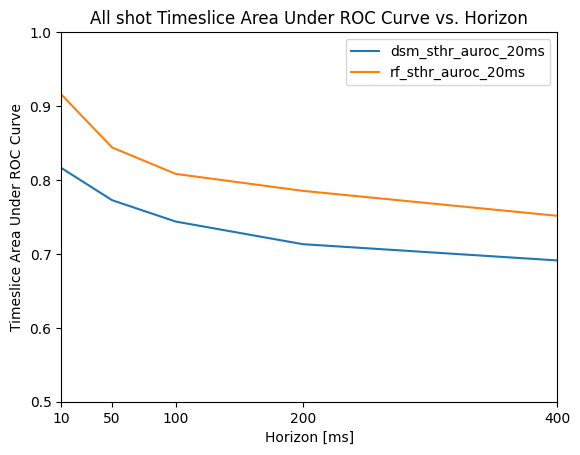

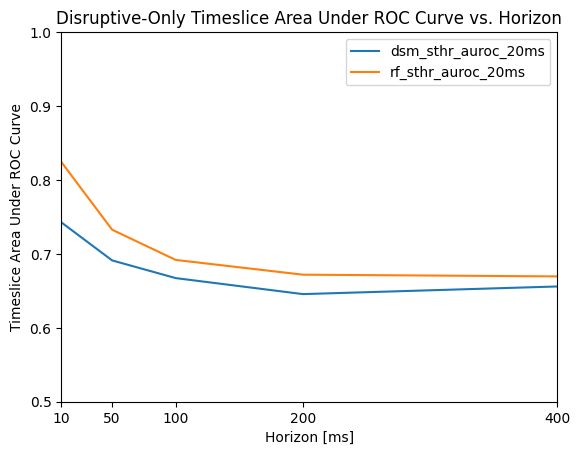

In [10]:
experiment_list = get_experiments(['dsm', 'auroc'], ['rf', 'auroc'])
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)
#plot_auroc_timeslice_shot_avg_vs_horizon(experiment_list)


## Table of Metrics:

In [11]:
required_warning_time = 0.02

result_data = []

#plot_TAR_vs_FAR(experiment_list, required_warning_time=required_warning_time)
#plot_warning_time_vs_FAR(experiment_list, required_warning_time=required_warning_time)

for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.ve

Model Performance when Reqired Warning Time is 20.0 ms


,Experiment Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,dsm_sthr_auroc_20ms,0.375517,2.181818,0.242424,0.2500,0.8125,[145.9000185132027],[109.68685222406354]
1,rf_sthr_auroc_20ms,0.440018,2.935537,0.256410,0.3125,1.1250,[114.73999619483948],[95.97270119209117]


## Area Under Warning Time Curve



c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.ve

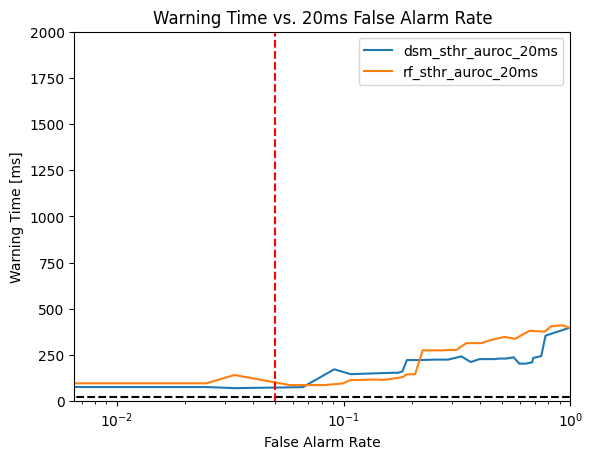

In [12]:
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05)

# One Model Type (several individual models)

Risk plotted against the actual shot.

Dotted line is the hyperparameter horizon / class time.
Solid line is required warning time.

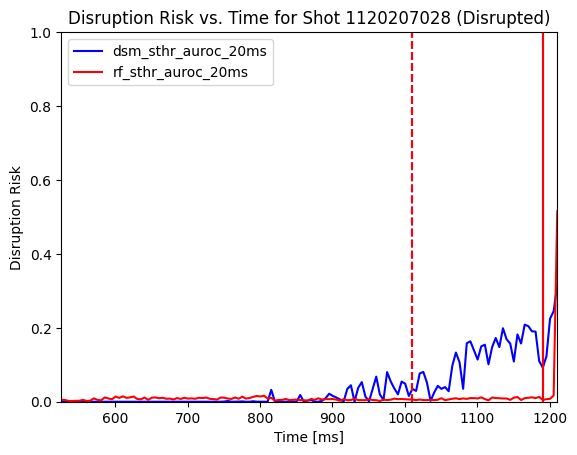

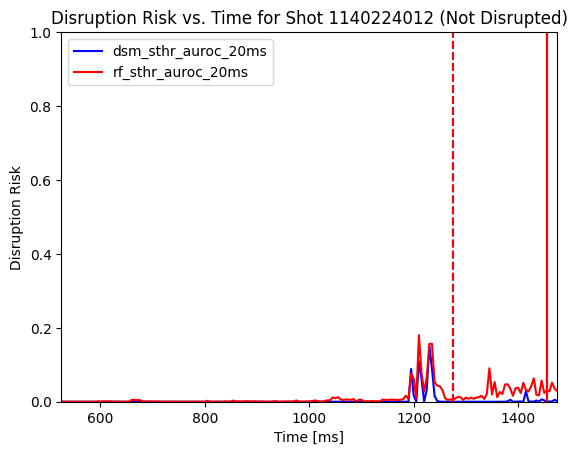

In [13]:
shot_number = experiment_list[0].get_disruptive_shot_list()[0]
plot_risk_compare_models(experiment_list, shot_number)
#plot_ettd_compare_models(experiment_list, shot_number)

shot_number = experiment_list[0].get_non_disruptive_shot_list()[0]
plot_risk_compare_models(experiment_list, shot_number)
#plot_ettd_compare_models(experiment_list, shot_number)

In [5]:
#plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])